<AxesSubplot:xlabel='X', ylabel='y'>

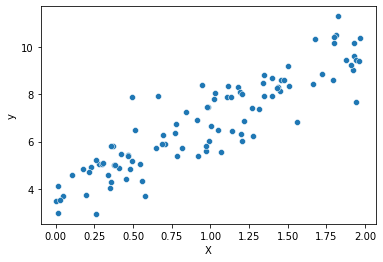

In [1]:
import numpy as np
import seaborn  as sns
import pandas as pd

# Create data set for linear regression
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)
rand_n = pd.DataFrame(np.concatenate((X,y), axis=1), columns=['X','y'])
sns.scatterplot(data=rand_n, x='X', y='y')

In [2]:
# Solve for best thetas
X_b = np.c_[np.ones((100,1)), X]
theta_best = (
    np.linalg
    .inv(X_b.T.dot(X_b))
    .dot(X_b.T).dot(y)
)
theta_best

array([[3.81003012],
       [3.07610408]])

In [3]:
# Make predictions using best theta
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[3.81003012],
       [9.96223828]])

(0.0, 2.0, 0.0, 15.0)

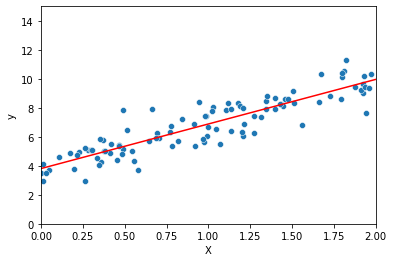

In [4]:
import matplotlib.pyplot as plt
sns.scatterplot(data=rand_n, x='X', y='y')
plt.plot(X_new,y_predict,'r-')
plt.axis([0,2,0,15])

#### Linear regression using Scikit-Learn

In [5]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
lin_reg.intercept_, lin_reg.coef_

(array([3.81003012]), array([[3.07610408]]))

In [6]:
lin_reg.predict(X_new)

array([[3.81003012],
       [9.96223828]])

In [15]:
# Implemnetation of gradient decent
import numpy as np

eta = 0.1
n_iterations = 1000
m = 100
vals = []
theta = np.random.randn(2,1)
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
    vals.append(theta)

theta

array([[3.81003012],
       [3.07610408]])

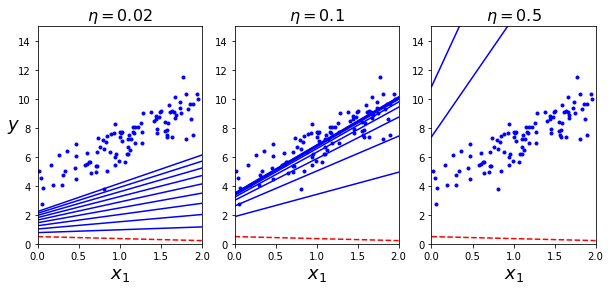

In [70]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)



Stochastic Gradient Descent w/ simple learning schedule

In [20]:
n_epochs = 50
t0, t1 = 5, 50
m = 100

def learning_schedule(t):
    return t0 / (t+t1)

theta = np.random.randn(2,1)

for epoch in range(n_epochs):
    for i in range(m):
        # Get random slice index of data
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        # Calculate the gradient vector
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        # Define the learning schedule
        eta = learning_schedule(epoch * m + i) # learning schedule gets smaller at every step.
        # Using the gradient vector, evaluate the gradient decent step. Move towards theta values towards true values.
        theta = theta - eta * gradients
        # after every training cycle in each epoch, the gradient vector get closer to true theta value.
# m = number of observations
# m is not used in the stochastic gradient function because each cost function is evaluated for each instance instead as a whole.

theta


array([[3.79682183],
       [3.10221628]])

what does the gradient represent?

* It represents the gradient descent step.

In [21]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(
    max_iter=1000, 
    tol=1e-3, # tolerance - code will run for 1000 iteration or loss drops by less the 1e-3
    penalty=None, # no regularization
    eta0=0.1 # learning rate
)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [22]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.82834663]), array([3.08669909]))

# Polynomial Regression

<AxesSubplot:xlabel='X', ylabel='y'>

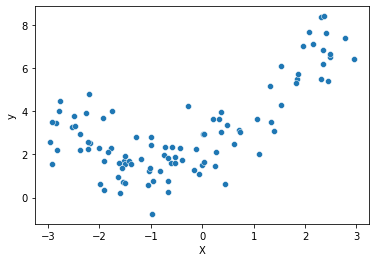

In [50]:
import pandas as pd

m = 100
X = 6 * np.random.rand(m,1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)
X = [val[0] for val in X.tolist()]
y = [val[0] for val in y.tolist()]
df = pd.DataFrame(zip(X,y), columns=['X','y'])
df
sns.scatterplot(x = 'X', y = 'y', data=df)